# 量化策略回测框架（优化版）

## 主要优化点:
1.  **资金分配优化**: 将初始资金等分成10份，每份用于独立的交易
2.  **持仓计算优化**: 使用独立的仓位管理，避免手续费重复计算
3.  **收益计算精确化**: 每笔交易使用独立的开平仓价格计算收益
4.  **交易成本精确计算**: 只在实际开仓/平仓时计算手续费

In [76]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path
from collections import defaultdict

---
## 1. 日志和绘图设置

In [77]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [ ]:
def run_optimized_backtest(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行优化版回测，解决手续费重复计算问题并实现资金等分
    
    核心优化:
    1. 将初始资金等分成10份，每份用于独立的交易
    2. 使用独立的仓位管理，避免手续费重复计算
    3. 每笔交易使用独立的开平仓价格计算收益
    4. 只在开仓/平仓时计算手续费
    
    参数:
    - prices (pd.Series): 'close'价格序列
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)
    - initial_capital (float): 初始资金
    - commission_rate (float): 单边交易手续费率
    - holding_period (int): 每笔交易的固定持有周期
    
    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame
    """
    logging.info(f"🚀 开始执行优化版回测 (资金等分, {holding_period}-period持有期)...")
    
    # 1. 初始化关键变量
    n_periods = len(prices)
    capital_per_trade = initial_capital / 10  # 每份交易资金
    portfolio_value = initial_capital         # 初始总资金
    equity_curve = np.zeros(n_periods)        # 资金曲线
    positions = defaultdict(list)             # 存储活跃仓位 {entry_index: [entry_price, signal_type, exit_index]}
    active_trades = []                        # 活跃交易列表
    transaction_costs = np.zeros(n_periods)   # 交易成本记录
    net_position = np.zeros(n_periods)        # 净持仓记录
    strategy_returns = np.zeros(n_periods)    # 策略收益率
    
    # 2. 主回测循环
    for i in range(1, n_periods):
        current_price = prices.iloc[i]
        
        # 2.1 处理到期仓位
        new_active_trades = []
        for trade in active_trades:
            entry_idx, entry_price, signal_type = trade
            # 检查是否到期 (i - entry_idx >= holding_period)
            if i - entry_idx >= holding_period:
                # 计算平仓收益
                if signal_type == 1:  # 多头平仓
                    trade_return = (current_price - entry_price) / entry_price
                else:  # 空头平仓
                    trade_return = (entry_price - current_price) / entry_price
                
                # 扣除平仓手续费
                trade_cost = capital_per_trade * commission_rate
                portfolio_value += capital_per_trade * trade_return - trade_cost
                transaction_costs[i] += trade_cost
            else:
                # 未到期，继续持有
                new_active_trades.append(trade)
        active_trades = new_active_trades
        
        # 2.2 处理新信号 (使用前一期信号)
        signal = signals.iloc[i-1]
        if signal != 0 and len(active_trades) < 10:  # 有信号且有空闲资金
            # 计算开仓手续费
            trade_cost = capital_per_trade * commission_rate
            portfolio_value -= trade_cost
            transaction_costs[i] += trade_cost
            
            # 记录新交易
            active_trades.append((i, current_price, signal))
        
        # 2.3 计算当前净持仓
        net_position[i] = sum(trade[2] for trade in active_trades)  # 信号值求和
        
        # 2.4 计算未实现盈亏
        unrealized_pnl = 0
        for trade in active_trades:
            entry_idx, entry_price, signal_type = trade
            if signal_type == 1:  # 多头
                unrealized_pnl += (current_price - entry_price) / entry_price * capital_per_trade
            else:  # 空头
                unrealized_pnl += (entry_price - current_price) / entry_price * capital_per_trade
        
        # 2.5 更新资金曲线和策略收益
        equity_curve[i] = portfolio_value + unrealized_pnl
        strategy_returns[i] = (equity_curve[i] - equity_curve[i-1]) / equity_curve[i-1] if equity_curve[i-1] != 0 else 0
    
    # 3. 构建结果DataFrame
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'net_position': net_position,
        'transaction_costs': transaction_costs,
        'strategy_net_returns': strategy_returns,
        'equity_curve': equity_curve
    }, index=prices.index)
    
    # 计算累计收益率
    backtest_results['cumulative_returns'] = (backtest_results['equity_curve'] / initial_capital - 1)
    
    logging.info("🎉 优化版回测完成")
    return backtest_results

In [79]:
def evaluate_performance_optimized(backtest_results, initial_capital):
    """
    评估优化策略表现
    """
    logging.info("📊 开始评估优化策略表现...")

    # --- 数据提取 ---
    net_returns = backtest_results['strategy_net_returns']
    equity_curve = backtest_results['equity_curve']
    cumulative_returns = backtest_results['cumulative_returns']
    
    # 基准是买入并持有
    market_returns = backtest_results['close'].pct_change().fillna(0)
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()

    # --- 交易统计 ---
    transaction_costs = backtest_results['transaction_costs']
    total_commission = transaction_costs.sum()
    
    # 计算交易次数 (开仓+平仓)
    trade_actions = (transaction_costs > 0).sum()
    total_trades = trade_actions // 2  # 每笔交易有开仓和平仓两次动作

    # --- 核心指标计算 ---
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.25 if total_days > 0 else 1

    # 1. 累积收益率
    total_return = cumulative_returns.iloc[-1]

    # 2. 年化收益率
    annualized_return = (1 + total_return) ** (1 / duration_years) - 1 if duration_years > 0 else 0

    # 3. 年化波动率
    daily_net_returns = net_returns.resample('D').sum()
    annualized_volatility = daily_net_returns.std() * np.sqrt(365) if not daily_net_returns.empty else 0

    # 4. 最大回撤
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()

    # 5. 夏普比率
    risk_free_rate = 0.00  # 假设无风险利率为0
    if annualized_volatility > 0:
        sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    else:
        sharpe_ratio = 0
        
    # 6. 卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else 0

    # --- 与理论基准比较 ---
    # 理论基准: signal * return (使用1/10资金权重)
    theoretical_returns = (backtest_results['signal'].shift(1) * market_returns).fillna(0)
    cumulative_theoretical = theoretical_returns.cumsum()
    correlation = cumulative_returns.corr(cumulative_theoretical)
    
    # 理论基准资金曲线
    theoretical_equity = initial_capital * (1 + cumulative_theoretical)

    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 20 + "优化策略性能评估报告" + " " * 20 + Style.RESET_ALL)
    print("="*80)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["回测模型", "资金等分独立仓位模型"],
        ["总收益率", f"{total_return:.2%}"],
        ["年化收益率", f"{annualized_return:.2%}"],
        ["年化波动率", f"{annualized_volatility:.2%}"],
        ["夏普比率", f"{sharpe_ratio:.4f}"],
        ["最大回撤", f"{max_drawdown:.2%}"],
        ["卡玛比率", f"{calmar_ratio:.4f}"],
        ["总交易次数", f"{total_trades}"],
        ["总手续费", f"${total_commission:,.2f}"],
        ["手续费/初始资金", f"{total_commission/initial_capital:.2%}"],
        [Fore.YELLOW + "与理论基准相关性" + Style.RESET_ALL, f"{correlation:.4f}"],
        ["最终资金", f"${equity_curve.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # --- 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(15, 7))
    
    # 资金曲线
    equity_curve.plot(label='Strategy Curve', lw=2.5, color='royalblue', ax=ax)
    benchmark_equity.plot(label='Buy & Hold', lw=1.5, linestyle='--', color='darkorange', ax=ax)
    theoretical_equity.plot(label="Theoretical Benchmark (signal*return)", lw=1.5, linestyle=':', color='purple', ax=ax)

    ax.set_title('Strategy Curve vs Benchmark', fontsize=16)
    ax.set_ylabel('Value ($)', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    logging.info("✅ 策略评估完成")

---
## 3. 主程序执行

2025-07-25 16:25:10,849 - INFO - 📂 从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-25 16:25:10,857 - INFO - ✅ 数据加载成功，共 131808 条记录
2025-07-25 16:25:10,857 - INFO - 数据时间范围: 2021-09-27 00:00:00 至 2025-06-30 23:45:00
2025-07-25 16:25:10,858 - INFO - 🚀 开始执行优化版回测 (资金等分, 10-period持有期)...
2025-07-25 16:25:12,168 - INFO - 🎉 优化版回测完成
2025-07-25 16:25:12,169 - INFO - 📊 开始评估优化策略表现...



                    优化策略性能评估报告                    
+------------------+----------------------+
|     指标名称     |          值          |
+==================+======================+
|     回测模型     | 资金等分独立仓位模型 |
+------------------+----------------------+
|     总收益率     |       -59.28%        |
+------------------+----------------------+
|    年化收益率    |       -21.27%        |
+------------------+----------------------+
|    年化波动率    |        39.48%        |
+------------------+----------------------+
|     夏普比率     |       -0.5389        |
+------------------+----------------------+
|     最大回撤     |        72.69%        |
+------------------+----------------------+
|     卡玛比率     |       -0.2926        |
+------------------+----------------------+
|    总交易次数    |        23193         |
+------------------+----------------------+
|     总手续费     |     $107,436.00      |
+------------------+----------------------+
| 手续费/初始资金  |       107.44%        |
+------------------+---------------------

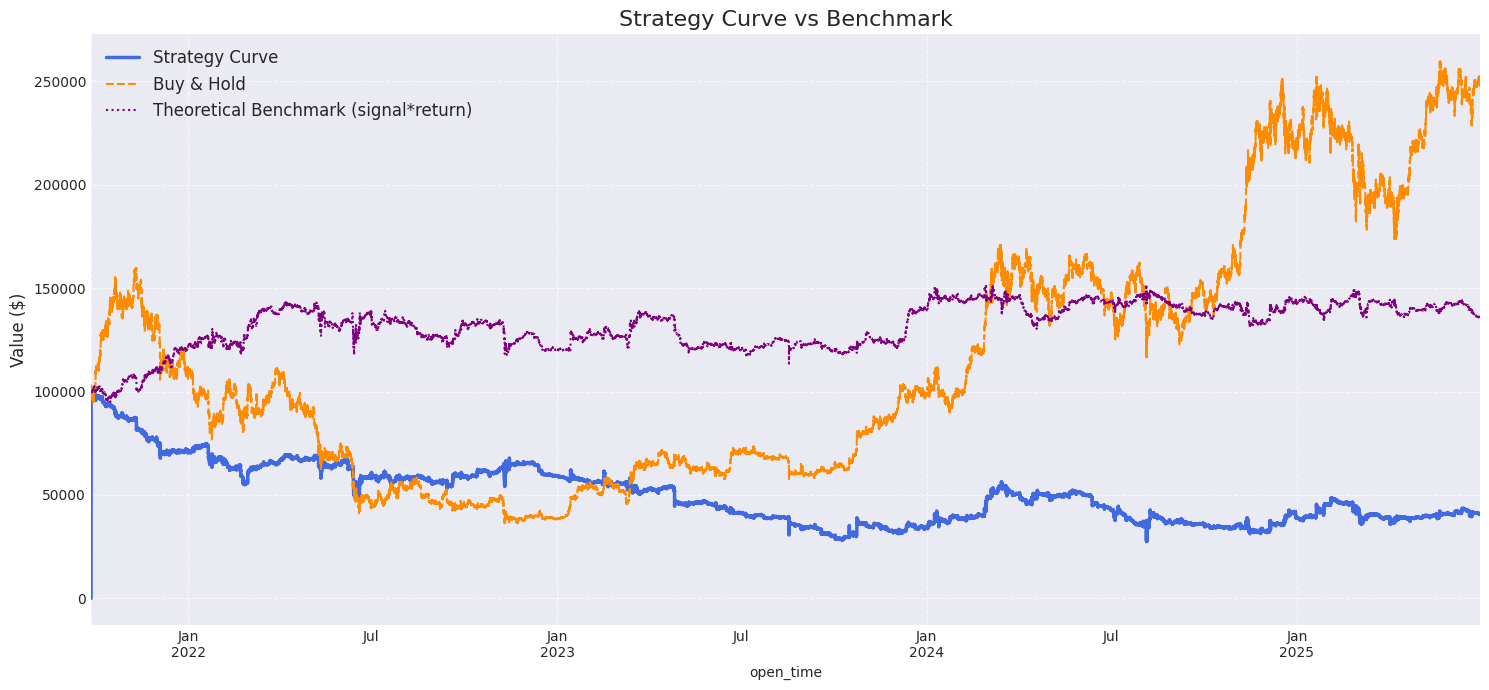

2025-07-25 16:25:16,350 - INFO - ✅ 策略评估完成


In [80]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # --- 2. 数据加载 ---
    logging.info(f"📂 从 {FILE_PATH} 加载数据...")
    
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # 确保索引是datetime类型
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')

        logging.info(f"✅ 数据加载成功，共 {len(data)} 条记录")
        logging.info(f"数据时间范围: {data.index[0]} 至 {data.index[-1]}")

    except FileNotFoundError:
        logging.error(f"❌ 错误: 数据文件未找到于路径 {FILE_PATH}")
        data = None
    except Exception as e:
        logging.error(f"❌ 加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用优化版函数) ---
    if data is not None:
        backtest_results = run_optimized_backtest(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )

        # --- 4. 性能评估 ---
        evaluate_performance_optimized(
            backtest_results, 
            INITIAL_CAPITAL
        )
    else:
        logging.warning("⚠️ 由于数据加载失败，回测和评估步骤已跳过。")